In [124]:
!pip install keras
!pip install matplotlib
!pip install pandas

In [125]:
import numpy as np
import pandas as pd

In [126]:
import matplotlib.pyplot as plt

In [127]:
!pip install scikit-learn
!pip install tensorflow
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os
import tensorflow as tf

In [128]:
df = pd.read_csv('FB_data.csv')
df.head(5)

,date,open,high,low,close,volume,Name
0,2013-02-08,28.89,29.17,28.51,28.5450,37662614,FB
1,2013-02-11,28.61,28.68,28.04,28.2600,36979533,FB
2,2013-02-12,27.67,28.16,27.10,27.3700,93417215,FB
3,2013-02-13,27.36,28.32,27.31,27.9075,50100805,FB
4,2013-02-14,28.02,28.63,28.01,28.5000,35581045,FB


preprocessing the data

In [129]:
df = df['close'].values
df = df.reshape(-1,1)

In [130]:
print(df.shape)

(1259, 1)


In [131]:
df[:5]

array([[28.545 ],
       [28.26  ],
       [27.37  ],
       [27.9075],
       [28.5   ]])

Forming the training and testing datasets

In [132]:
dataset_train=np.array(df[:int(df.shape[0]*0.8)])
print(dataset_train.shape)

(1007, 1)


In [133]:
dataset_test=np.array(df[int(df.shape[0]*0.8)-50:])
print(dataset_test.shape)

(302, 1)


In [134]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_train[:5]

array([[0.05115011],
       [0.04856814],
       [0.04050516],
       [0.04537466],
       [0.05074243]])

In [135]:
dataset_test = scaler.transform(dataset_test)
dataset_test[:5]

array([[0.88313206],
       [0.88340385],
       [0.88757123],
       [0.86537538],
       [0.83529774]])

In [136]:
def create_dataset(df):
    x=[]
    y=[]
    for i in range(50,df.shape[0]):
         x.append(df[i-50:i,0])
         y.append(df[i,0])
    x=np.array(x)
    y=np.array(y)
    return x,y

In [137]:
x_train, y_train = create_dataset(dataset_train)
x_train[:1]
y_train[:1]

array([0.02791241])

In [138]:
x_test, y_test = create_dataset(dataset_test)
x_test[:1]

array([[0.88313206, 0.88340385, 0.88757123, 0.86537538, 0.83529774,
        0.8380156 , 0.85640645, 0.8553193 , 0.8611174 , 0.86981455,
        0.87679039, 0.85948669, 0.88249789, 0.88159194, 0.88485337,
        0.8785117 , 0.8728042 , 0.87144527, 0.87099229, 0.85613466,
        0.85495692, 0.86166097, 0.85178609, 0.84662215, 0.83484476,
        0.85124251, 0.86782145, 0.88575932, 0.91058244, 0.92408114,
        0.9190984 , 0.93486198, 0.93966353, 0.95524592, 0.95098794,
        0.95144092, 0.94808889, 0.94346853, 0.96059104, 0.96457724,
        0.98369285, 0.99547023, 0.99003452, 0.97916308, 0.97318379,
        0.99954702, 0.97789475, 0.97916308, 0.98894737, 0.98695428]])

reshaping the data to be fed to LSTM

In [139]:
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
print(x_train.shape)

(957, 50, 1)


In [140]:
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
print(x_test.shape)

(252, 50, 1)


building the model

In [141]:
model = Sequential()
model.add(LSTM(units=96,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 50, 96)            37632     
_________________________________________________________________
dropout_12 (Dropout)         (None, 50, 96)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 50, 96)            74112     
_________________________________________________________________
dropout_13 (Dropout)         (None, 50, 96)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 96)                74112     
_________________________________________________________________
dropout_14 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [142]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])
if(not os.path.exists(r'Stock_Price_Prediction.h5')):
 model.fit(x_train,y_train,epochs=55, batch_size=32)
 model.save(r'Stock_Price_Prediction.h5')

In [143]:
model = load_model(r'Stock_Price_Prediction.h5')

Visualising the predictions

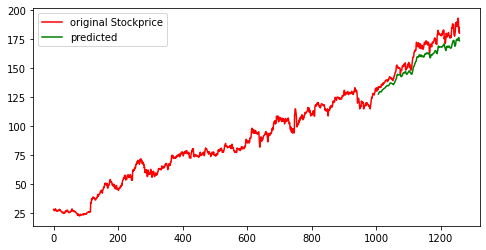

In [144]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
fig, ax= plt.subplots(figsize=(8,4))
plt.plot(df,color='red',label='original Stockprice')
ax.plot(range(len(y_train)+50,len(y_train)+50+len(predictions)),predictions,color='green',label=
        'predicted')
plt.legend()

In [145]:
print(range(len(y_train)+50, len(y_train)+50+len(predictions)))

range(1007, 1259)


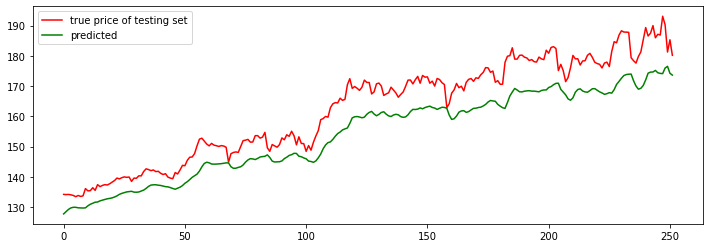

In [146]:
y_test_scaled=scaler.inverse_transform(y_test.reshape(-1,1))
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(y_test_scaled,color='red',label='true price of testing set')
plt.plot(predictions,color='green',label='predicted')
plt.legend()